In [1]:
import pandas as pd
import numpy as np
import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/justinchen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
df = pd.read_csv('/Users/justinchen/Desktop/AARD Datasets/all_subreddits.csv')

In [3]:
df.tail()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
249995,16802881,unemployment,1586483390,Yeah I believe you are right.\n\nLook at the g...,0.8402
249996,9285909,askreddit,1609412233,"No offense taken, we all grew up under differe...",-0.5885
249997,10237762,iama,1606925404,"James here: Really good question. So, the answ...",-0.9417
249998,12742373,asktrumpsupporters,1599704873,Flip flopping on covid information. Not sure i...,0.3002
249999,6810474,formula1,1616861249,We need more covid,0.0000


In [57]:
df.dropna(axis = 0, how = 'any')

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,Carmen Legge was at the Northville Farm ([http...,0.0000
1,13261673,ukpolitics,1597987216,You don't need to be an expert to see that Bor...,0.0000
2,261403,amazonfc,1634437900,Just made a month! lol and I’ve worked at amaz...,0.7818
3,15681814,drugs,1590316428,It looks like you're discussing that thing. Co...,0.8391
4,3153614,politics,1628274205,"&gt;“Decent covid response” yes, killing the s...",0.7289
...,...,...,...,...,...
249995,16802881,unemployment,1586483390,Yeah I believe you are right.\n\nLook at the g...,0.8402
249996,9285909,askreddit,1609412233,"No offense taken, we all grew up under differe...",-0.5885
249997,10237762,iama,1606925404,"James here: Really good question. So, the answ...",-0.9417
249998,12742373,asktrumpsupporters,1599704873,Flip flopping on covid information. Not sure i...,0.3002


## Preprocessing

In [5]:
import re
import demoji 
demoji.download_codes()

/var/folders/q6/mkn146812pz0n3cx40bgg__40000gn/T/ipykernel_82667/79378484.py:3: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


In [6]:
def pre_cleaning(text):
    line = re.sub(r"\Bu/\w+", ' ', text) #remove usernames
    line = demoji.replace(line, repl=' ')
    return line

In [7]:
#removing stopwords and urls, stemming, making lowercase 
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

def cleaning(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stTem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [11]:
def post_cleaning(text):
    # Remove special characters
    feature = re.sub(r'\W', ' ',text)

    # remove single characters
    feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', feature)

    # Remove single characters from the start
    feature = re.sub(r'\^[a-zA-Z]\s+', ' ', feature) 
    
    #remove digits
    feature = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", feature)

    # Substituting multiple spaces with single space
    feature = re.sub(r'\s+', ' ', feature, flags=re.I)

    return feature

In [12]:
#above functions combined
def preprocessing(text):
    line = cleaning(text)
    line = post_cleaning (line)
    return line

In [58]:
df.body = df.body.apply(lambda x: preprocessing(x))

In [14]:
df.head()

,Unnamed: 0,subreddit.name,created_utc,body,sentiment
0,7951721,oakisland,1613168164,carmen legge northville farm centerville nova ...,0.0000
1,13261673,ukpolitics,1597987216,need expert see boris covid brexit fall guy,0.0000
2,261403,amazonfc,1634437900,made month lol worked amazon covid hit whole f...,0.7818
3,15681814,drugs,1590316428,looks like discussing thing contact medical em...,0.8391
4,3153614,politics,1628274205,gt decent covid response yes killing states ec...,0.7289


In [76]:
sample = df.sample(20000)

In [77]:
for sentiment in sample['sentiment']:
    if sentiment > 0:
        sample['sentiment'].replace({sentiment : 'positive'}, inplace=True)
    if sentiment <= 0:
        sample['sentiment'].replace({sentiment : 'negative'}, inplace=True)
#     else:
#         sample['sentiment'].replace({sentiment : 'neutral'}, inplace=True)

Text(0.5, 1.0, 'Sentiment Data Distribution')

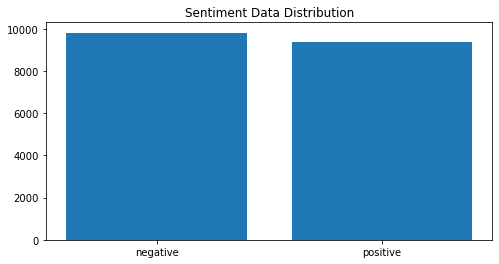

In [78]:
#Graphing
val_count = sample.sentiment.value_counts()
plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [18]:
from sklearn.model_selection import train_test_split

In [79]:
 # Splits Dataset into Training and Testing set
train_size = 0.8
train_data, test_data = train_test_split(sample, test_size=1-train_size, random_state=42, shuffle=True)
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 16000
Test Data size 4000


## Model

In [22]:
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.preprocessing import LabelEncoder

In [80]:
lb=LabelEncoder()
sample['sentiment'] = lb.fit_transform(sample['sentiment'])

In [81]:
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(sample['body'].values)
X = tokenizer.texts_to_sequences(sample['body'].values)
X = pad_sequences(X, maxlen = 300)

In [49]:
X.shape

(20000, 600)

In [50]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaler.transform(X)

array([[ 0.        ,  0.        ,  0.        , ..., -0.89255323,
        -0.93275709,  0.06217387],
       [ 0.        ,  0.        ,  0.        , ..., -0.89255323,
        -0.59566449,  0.39334505],
       [ 0.        ,  0.        ,  0.        , ...,  1.32609308,
        -0.49525393, -0.52970655],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.70032104,
        -0.94710145, -0.41696742],
       [ 0.        ,  0.        ,  0.        , ..., -0.31655852,
        -0.05057859, -0.55789133],
       [ 0.        ,  0.        ,  0.        , ...,  1.00609602,
        -0.73910815, -0.2901359 ]])

In [82]:
y = sample['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [107]:
model = Sequential()
model.add(Embedding(X.shape[0], 64, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'BinaryCrossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])
print(model.summary())

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 300, 64)           1280000   
                                                                 
 spatial_dropout1d_18 (Spati  (None, 300, 64)          0         
 alDropout1D)                                                    
                                                                 
 lstm_18 (LSTM)              (None, 176)               169664    
                                                                 
 dense_18 (Dense)            (None, 1)                 177       
                                                                 
Total params: 1,449,841
Trainable params: 1,449,841
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
batch_size=64
model.fit(X_train, y_train, epochs = 5, batch_size=batch_size, verbose = 'auto')

Epoch 1/5
250/250 [==============================] - 3314s 13s/step - loss: -0.0878 - accuracy: 0.5971
Epoch 2/5
250/250 [==============================] - 238s 951ms/step - loss: -0.4776 - accuracy: 0.6105
Epoch 3/5
250/250 [==============================] - 245s 981ms/step - loss: -0.8159 - accuracy: 0.6170
Epoch 4/5
250/250 [==============================] - 249s 994ms/step - loss: -1.2019 - accuracy: 0.6261
Epoch 5/5
228/250 [==========================>...] - ETA: 21s - loss: -1.5195 - accuracy: 0.6335

In [106]:
model.evaluate(X_test,y_test)

125/125 [==============================] - 10s 71ms/step - loss: -0.3563 - accuracy: 0.6227


[-0.35629770159721375, 0.6227499842643738]

In [258]:
train_data = train_data.reset_index()
test_data = test_data.reset_index()

In [259]:
bs = 64
cut = int(50000 * 0.8)
dls = DataLoaders.from_dsets(train_data, test_data, bs=64, shuffle=False)

In [260]:
class LModel(Module):
    def __init__(self, vocab_sz, n_hidden, n_layers):
        self.i_h = nn.Embedding(vocab_sz, n_hidden)
        self.rnn = nn.LSTM(n_hidden, n_hidden, n_layers, batch_first=True)
        self.h_o = nn.Linear(n_hidden, vocab_sz)
        self.h = [torch.zeros(n_layers, bs, n_hidden) for _ in range(2)]
        
    def forward(self, x):
        res,h = self.rnn(self.i_h(x), self.h)
        self.h = [h_.detach() for h_ in h]
        return self.h_o(res)
    
    def reset(self): 
        for h in self.h: h.zero_()

In [39]:
vocab = vectorizer.get_feature_names()

/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [254]:
import torch

In [261]:
learn = Learner(dls, LModel(len(vocab), 64, 2), 
                loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy, cbs=ModelResetter)
learn.fit_one_cycle(15, 3e-3)

epoch,train_loss,valid_loss,accuracy,time


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3361, in get_loc
    return self._engine.get_loc(casted_key)
  File "pandas/_libs/index.pyx", line 76, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 108, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 5198, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 5206, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 0

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 39, in fetch
    data = next(self.dataset_iter)
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastai/data/load.py", line 118, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastcore/basics.py", line 217, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastai/data/load.py", line 133, in do_item
    try: return self.after_item(self.create_item(s))
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/fastai/data/load.py", line 140, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py", line 3458, in __getitem__
    indexer = self.columns.get_loc(key)
  File "/Users/justinchen/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexes/base.py", line 3363, in get_loc
    raise KeyError(key) from err
KeyError: 0
